In [1]:
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from matplotlib.gridspec import GridSpec
import numpy as np
import regionmask
from scipy import stats 
import seaborn as sns
import xarray as xr

from src import tools

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# Original simulations (same function as in Fig1)
def get_original_values_diff(variable, sim, sim_SNOx, conversion_factor=1, resolution='c48'):
    ds = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{sim}.MDA8_O3.april-august.nc4")
    ds_SNOx = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{sim_SNOx}.MDA8_O3.april-august.nc4")

    ds_diff = ds_SNOx-ds

    da = ds_diff[variable]*conversion_factor
    
    if "lev" in da.dims:
        da = da.isel(lev=0)
    da_monthly = da.resample(time='1M').mean(dim='time')
    da_monthly_noland = tools.mask_ocean_c48(da_monthly)
    return da_monthly_noland

variable = "SpeciesConc_O3"
ref = get_original_values_diff(variable, "all_ref_c48", "all_refSNOx_c48", conversion_factor=1e9, resolution='c48')
refshort = get_original_values_diff(variable, "all_refshort_c48", "all_refSNOxshort_c48", conversion_factor=1e9, resolution='c48')
polshort = get_original_values_diff(variable, "all_polshort_c48", "all_polSNOxshort_c48", conversion_factor=1e9, resolution='c48')

/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:


In [3]:
# Part 1: Regional-mean dO3dENOx
comparison_months = [4,5,6,7,8]
calculate_mean = lambda da: da.sel(time=da.time.dt.month.isin(comparison_months)).resample(time='1Y').mean()
ref_mean = calculate_mean(ref)
refshort_mean = calculate_mean(refshort)
polshort_mean = calculate_mean(polshort)

/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:


In [4]:
# Part 2: Grid-box days

# Original simulations
def get_original_values_ratio(variable, sim, sim_SNOx, resolution='c48'):
    ds = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{sim}.MDA8_O3.april-august.nc4")
    ds_SNOx = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{sim_SNOx}.MDA8_O3.april-august.nc4")

    ds_ratio = ds_SNOx/ds

    da = ds_ratio[variable]
    
    if "lev" in da.dims:
        da = da.isel(lev=0)

    da_noland = tools.mask_ocean_c48(da)
    return da_noland

variable = "SpeciesConc_O3"
ref_ratio = get_original_values_ratio(variable, "all_ref_c48", "all_refSNOx_c48", resolution='c48')
refshort_ratio = get_original_values_ratio(variable, "all_refshort_c48", "all_refSNOxshort_c48", resolution='c48')
polshort_ratio = get_original_values_ratio(variable, "all_polshort_c48", "all_polSNOxshort_c48",resolution='c48')


In [5]:
def get_regional_days_per_month(region_num, months, present_ratio, future_ratio):
    
    # Select specific months
    present_ratio = present_ratio.sel(time=present_ratio.time.dt.month.isin(months))
    future_ratio = future_ratio.sel(time=future_ratio.time.dt.month.isin(months))

    # Select region
    present_ratio = tools.crop_regionmask_ar6_c48(present_ratio, region_num)
    future_ratio = tools.crop_regionmask_ar6_c48(future_ratio, region_num) 

    # Remove "region" dimension
    if "region" in present_ratio.dims:
        present_ratio = present_ratio.isel(region=0)
    
    if "region" in future_ratio.dims:
        future_ratio = future_ratio.isel(region=0)

    # Compute disbenefit-days (ratio > 1)
    present_days = present_ratio.where(present_ratio > 1).resample(time='1Y').count(dim=['time','Ydim','Xdim', 'nf'])
    future_days = future_ratio.where(future_ratio > 1).resample(time='1Y').count(dim=['time','Ydim','Xdim', 'nf'])

    # Retrieve values
    present_days_values = present_days.values.flatten() # present
    future_days_values = future_days.values.flatten() # future-high

    # Remove nans (means from seasons other than selected above will be nan)
    present_days_values = present_days_values[~np.isnan(present_days_values)]
    future_days_values = future_days_values[~np.isnan(future_days_values)]

    return present_days_values, future_days_values

In [6]:
# Part 2: Grid-box days
comparison_months = comparison_months

region_num = 5
ENA_present, ENA_future = get_regional_days_per_month(region_num, comparison_months, ref_ratio, refshort_ratio)

region_num = 17
WCE_present, WCE_future = get_regional_days_per_month(region_num, comparison_months, ref_ratio, refshort_ratio)

region_num = 58
EAS_present, EAS_future = get_regional_days_per_month(region_num, comparison_months, ref_ratio, refshort_ratio)

region_num = 5
ENA_present, ENA_futurepol = get_regional_days_per_month(region_num, comparison_months, ref_ratio, polshort_ratio)

region_num = 17
WCE_present, WCE_futurepol = get_regional_days_per_month(region_num, comparison_months, ref_ratio, polshort_ratio)

region_num = 58
EAS_present, EAS_futurepol = get_regional_days_per_month(region_num, comparison_months, ref_ratio, polshort_ratio)


/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-

In [7]:
def plot_histogram(ax, data1, data2, num_bins, title, color2):
    """
    Helper function to plot histograms and calculate KS-test p-value.
    """
    min_val = min(np.concatenate([data1]).min(), np.concatenate([data2]).min())
    max_val = max(np.concatenate([data1]).max(), np.concatenate([data2]).max())
    
    sns.histplot(data1, bins=num_bins, binrange=[min_val, max_val],
                 stat="density", ax=ax, kde=False, color='black',
                 edgecolor="k", linewidth=0.5, alpha=0.65)
    sns.histplot(data2, bins=num_bins, binrange=[min_val, max_val],
                 stat="density", ax=ax, kde=False, color=color2,
                 edgecolor="k", linewidth=0.5, alpha=0.65)
    
    # KS-test
    _, pval_ks = stats.ks_2samp(data1, data2)
    formatted_pval_ks = format(pval_ks, ".3f")
    ax.text(.02, 1.11, f"p(KS-test)={formatted_pval_ks}", ha='left', va='top',
            transform=ax.transAxes, color=color2, fontsize=6)
    ax.text(.02, 1.24, title, ha='left', va='top', transform=ax.transAxes, color='black', fontsize=8)

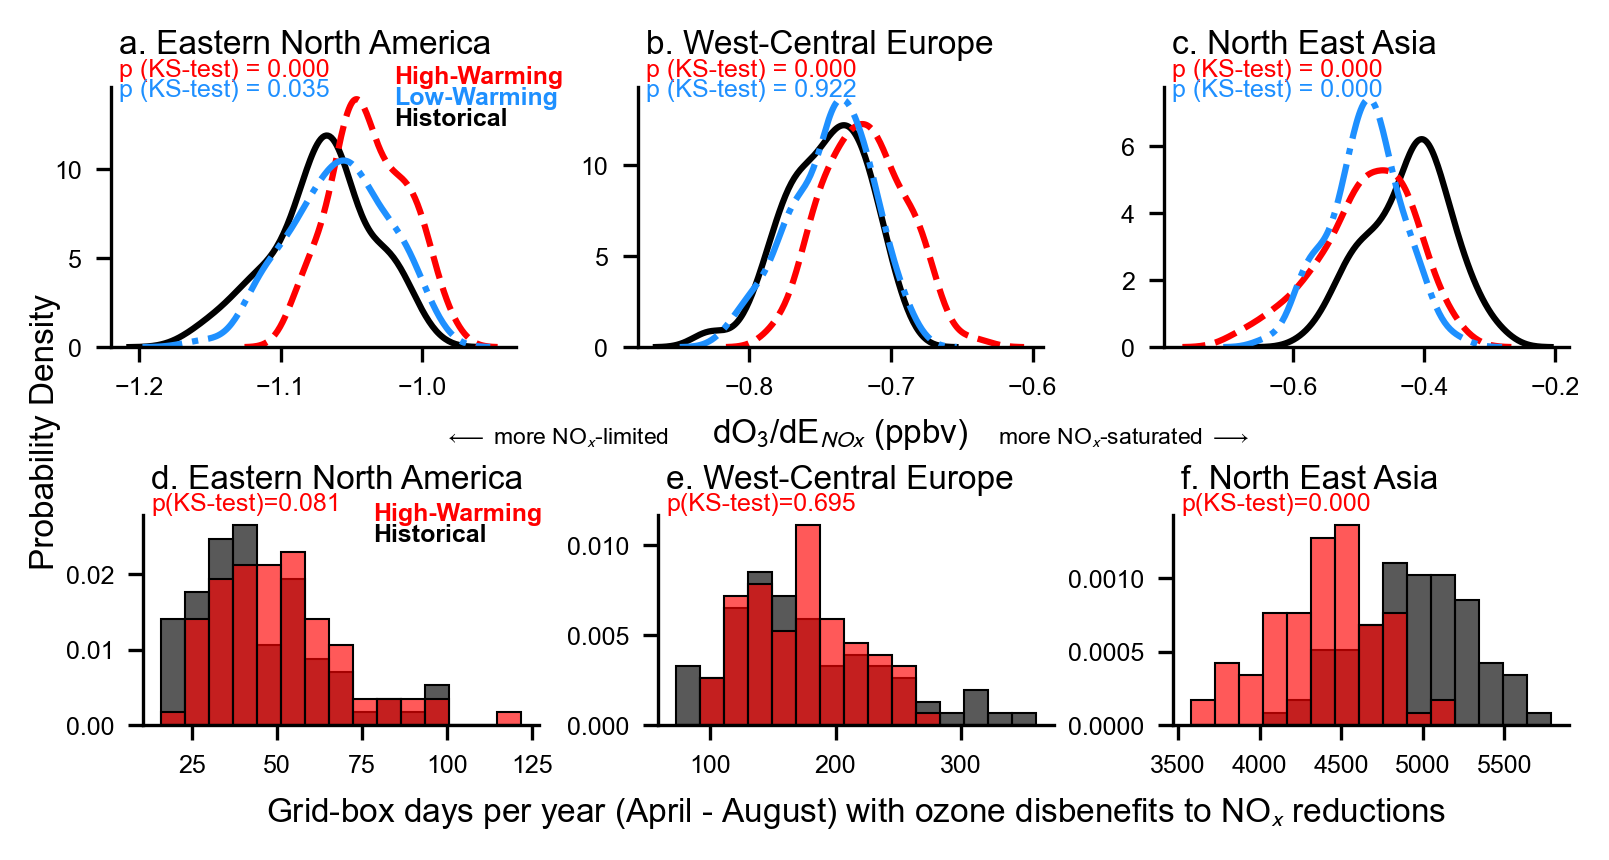

In [ ]:
tools.set_matplotlib_font("Arial")

mpl.rcParams.update({
    'axes.edgecolor': 'black',      
    'xtick.color': 'black',         
    'ytick.color': 'black',         
    'xtick.labelcolor': 'black',    
    'ytick.labelcolor': 'black',    
    'grid.color': 'black',          
    'axes.labelcolor': 'black',     
    'axes.titlecolor': 'black',
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 6,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6, 
    'legend.fontsize': 6,
    'figure.titlesize': 8
})

fig = plt.figure(figsize=(5.4, 2.8), dpi=300)
gs1 = GridSpec(1, 3, top=0.91, bottom=0.60, left=0.07, right=0.97, hspace=0.50, wspace=0.3)
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[0, 2])
gs2 = GridSpec(1, 3, top=0.40, bottom=0.15, left=0.09, right=0.97, hspace=0.50, wspace=0.3)
ax4 = fig.add_subplot(gs2[0, 0])
ax5 = fig.add_subplot(gs2[0, 1])
ax6 = fig.add_subplot(gs2[0, 2])

##################################################################
# Part 1 
axes = [ax1, ax2, ax3]
titles = [
    "a. Eastern North America", "b. West-Central Europe", "c. North East Asia",
]
ar6_region = {"ENA": 5, "EAS": 58, "WCE": 17}

# Prep storage lists (not used)
all_present_values, all_future_values, all_futurepol_values = [], [], []
all_regions = []

# Loop over regions
for region, idx in zip(["ENA", "WCE", "EAS"], [0,1,2]):
    
    # Crop data once per region
    present_reg = tools.crop_regionmask_ar6_c48(ref_mean, region_num=ar6_region[region])
    future_reg = tools.crop_regionmask_ar6_c48(refshort_mean, region_num=ar6_region[region])  
    futurepol_reg = tools.crop_regionmask_ar6_c48(polshort_mean, region_num=ar6_region[region])    
    
    # Compute spatial average
    present_reg_mean = present_reg.mean(dim=['nf', 'Ydim', 'Xdim'])
    future_reg_mean = future_reg.mean(dim=['nf', 'Ydim', 'Xdim'])
    futurepol_reg_mean = futurepol_reg.mean(dim=['nf', 'Ydim', 'Xdim'])

    present_values   = present_reg_mean.values.flatten()
    future_values    = future_reg_mean.values.flatten()
    futurepol_values = futurepol_reg_mean.values.flatten()
        
    all_present_values.append(present_values)
    all_future_values.append(future_values)
    all_futurepol_values.append(futurepol_values)
    
    all_regions.append(region)

    ax = axes[idx]
        
    # KDE plots
    sns.kdeplot(data=present_values, ax=ax, color='black', linestyle='-', fill=False, legend='brief')
    sns.kdeplot(data=future_values, ax=ax, color='red', linestyle='--', fill=False, legend='brief')
    sns.kdeplot(data=futurepol_values, ax=ax, color='dodgerblue', linestyle='-.', fill=False, legend='brief')

    # KS-tests
    _, pval_future = stats.ks_2samp(present_values, future_values)
    _, pval_futurepol = stats.ks_2samp(present_values, futurepol_values)

    # P-values and titles
    ax.text(0.02, 1.22, titles[idx], ha='left', va='top', transform=ax.transAxes, color='k', fontsize=8)
    ax.text(0.02, 1.11, f"p (KS-test) = {pval_future:.3f}", ha='left', va='top', transform=ax.transAxes, color='red', fontsize=6)
    ax.text(0.02, 1.03, f"p (KS-test) = {pval_futurepol:.3f}", ha='left', va='top', transform=ax.transAxes, color='dodgerblue', fontsize=6)

    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
        ax.set(xlabel=None, ylabel=None)

ax2.text(-0.6, 1.08, "High-Warming", ha='left', va='top', transform=ax2.transAxes, color='red', fontsize=6, fontweight='bold')
ax2.text(-0.6, 1.00, "Low-Warming", ha='left', va='top', transform=ax2.transAxes, color='dodgerblue', fontsize=6, fontweight='bold')
ax2.text(-0.6, 0.92, "Historical", ha='left', va='top', transform=ax2.transAxes, color='black', fontsize=6, fontweight='bold')

ylabel = "Probability Density"
axes[1].set_xlabel(r"dO$_3$/dE$_{NOx}$ (ppbv)", fontsize=8)
axes[1].text(-0.2, -0.37, r"$\longleftarrow$ more NO$_x$-limited", fontsize=5.5, transform=axes[1].transAxes, ha="center")
axes[1].text(1.2, -0.37, r"more NO$_x$-saturated $\longrightarrow$", fontsize=5.5, transform=axes[1].transAxes, ha="center")

###############################################
# Part 2 
axes = [ax4, ax5, ax6]
titles = [
    "d. Eastern North America", "e. West-Central Europe", "f. North East Asia",
]
datasets = [
    (ENA_present, ENA_future, "red"), 
    (WCE_present, WCE_future, "red"), 
    (EAS_present, EAS_future, "red"), 
]

num_bins = 15
for i, (data1, data2, color2) in enumerate(datasets):
    plot_histogram(axes[i], data1, data2, num_bins, titles[i], color2)

for ax in axes:
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel(None)
    ax.tick_params(axis='both', labelsize=6)
axes[1].set_xlabel("Grid-box days per year (April - August) with ozone disbenefits to NO$_x$ reductions", fontsize=8)

ax4.text(0.58, 1.06, "High-Warming", ha='left', va='top', transform=ax4.transAxes, color='red', fontsize=6, fontweight='bold')
ax4.text(0.58, 0.96, "Historical", ha='left', va='top', transform=ax4.transAxes, color='black', fontsize=6, fontweight='bold')


fig.supylabel(ylabel)

###############################################

plt.savefig("Fig2_new.pdf")

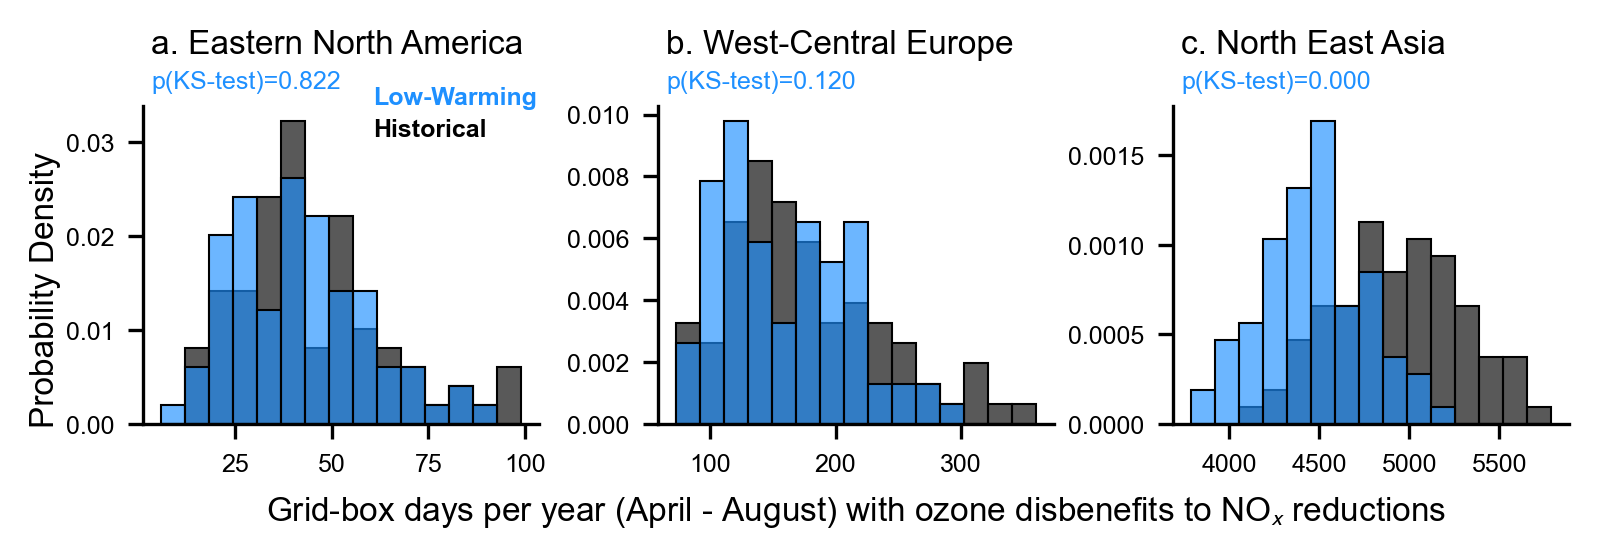

In [37]:
tools.set_matplotlib_font("Arial")

mpl.rcParams.update({
    'axes.edgecolor': 'black',      
    'xtick.color': 'black',         
    'ytick.color': 'black',         
    'xtick.labelcolor': 'black',    
    'ytick.labelcolor': 'black',    
    'grid.color': 'black',          
    'axes.labelcolor': 'black',     
    'axes.titlecolor': 'black',
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 6,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6, 
    'legend.fontsize': 6,
    'figure.titlesize': 8
})

fig = plt.figure(figsize=(5.4, 1.8), dpi=300)
gs1 = GridSpec(1, 3, top=0.84, bottom=0.25, left=0.09, right=0.97, hspace=0.50, wspace=0.3)
ax4 = fig.add_subplot(gs1[0, 0])
ax5 = fig.add_subplot(gs1[0, 1])
ax6 = fig.add_subplot(gs1[0, 2])

###############################################
# Part 2 
axes = [ax4, ax5, ax6]
titles = [
    "a. Eastern North America", "b. West-Central Europe", "c. North East Asia",
]
datasets = [
    (ENA_present, ENA_futurepol, "dodgerblue"), 
    (WCE_present, WCE_futurepol, "dodgerblue"), 
    (EAS_present, EAS_futurepol, "dodgerblue"), 
]

num_bins = 15
for i, (data1, data2, color2) in enumerate(datasets):
    plot_histogram(axes[i], data1, data2, num_bins, titles[i], color2)

for ax in axes:
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel(None)
    ax.tick_params(axis='both', labelsize=6)  # Adjust tick label size
axes[1].set_xlabel("Grid-box days per year (April - August) with ozone disbenefits to NO$_x$ reductions", fontsize=8)

ax4.text(0.58, 1.06, "Low-Warming", ha='left', va='top', transform=ax4.transAxes, color='dodgerblue', fontsize=6, fontweight='bold')
ax4.text(0.58, 0.96, "Historical", ha='left', va='top', transform=ax4.transAxes, color='black', fontsize=6, fontweight='bold')


fig.supylabel(ylabel)

###############################################

plt.savefig("FigS4_new.png")

In [38]:
# Calculate total number of grid boxes per region

print("Total number of grid boxes in ENA:")
da = tools.crop_regionmask_ar6_c48(ref_ratio, 5)
da_map = da.mean(dim=['sim','time','region'])
print(da_map.count().values)

print("Total number of grid boxes in WCE:")
da = tools.crop_regionmask_ar6_c48(ref_ratio, 17)
da_map = da.mean(dim=['sim','time','region'])
print(da_map.count().values)

print("Total number of grid boxes in NEA:")
da = tools.crop_regionmask_ar6_c48(ref_ratio, 58)
da_map = da.mean(dim=['sim','time','region'])
print(da_map.count().values)

Total number of grid boxes in ENA:
161
Total number of grid boxes in WCE:
148
Total number of grid boxes in NEA:
138


In [39]:
# Calculate mean and standard deviation of NEA disbenefit days
print("Historical ozone disbenefit days in NEA:")
print(np.mean(EAS_present))
print(np.std(EAS_present))

print("High-warming ozone disbenefit days in NEA:")
print(np.mean(EAS_future))
print(np.std(EAS_future))

print("Low-warming ozone disbenefit days in NEA:")
print(np.mean(EAS_futurepol))
print(np.std(EAS_futurepol))

Historical ozone disbenefit days in NEA:
4939.75
362.2934066471539
High-warming ozone disbenefit days in NEA:
4397.0875
333.64457862184724
Low-warming ozone disbenefit days in NEA:
4473.3875
288.64803367379795
